In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
import os

sys.path.append("/home/jovyan/camels/proj1/")
from setup_params import get_safe_name, get_colour_dir_name, get_magnitude_mask
from variables_config import get_config


In [9]:
parameter_dict = {
    "1P_p1_n2": {"parameter": "Omega M", "value": 0.1},
    "1P_p1_n1": {"parameter": "Omega M", "value": 0.2},
    "1P_p1_0": {"parameter": "Omega M", "value": 0.3},
    "1P_p1_1": {"parameter": "Omega M", "value": 0.4},
    "1P_p1_2": {"parameter": "Omega M", "value": 0.5},
    "1P_p2_n2": {"parameter": "Sigma 8", "value": 0.6},
    "1P_p2_n1": {"parameter": "Sigma 8", "value": 0.7},
    "1P_p2_0": {"parameter": "Sigma 8", "value": 0.8},
    "1P_p2_1": {"parameter": "Sigma 8", "value": 0.9},
    "1P_p2_2": {"parameter": "Sigma 8", "value": 1.0},
    "1P_p3_n2": {"parameter": "WindEnergyIn1e51erg (SN1)", "value": 0.9},
    "1P_p3_n1": {"parameter": "WindEnergyIn1e51erg (SN1)", "value": 1.8},
    "1P_p3_0": {"parameter": "WindEnergyIn1e51erg (SN1)", "value": 3.6},
    "1P_p3_1": {"parameter": "WindEnergyIn1e51erg (SN1)", "value": 7.2},
    "1P_p3_2": {"parameter": "WindEnergyIn1e51erg (SN1)", "value": 14.4},
    "1P_p4_n2": {"parameter": "RadioFeedbackFactor (AGN1)", "value": 0.25},
    "1P_p4_n1": {"parameter": "RadioFeedbackFactor (AGN1)", "value": 0.5},
    "1P_p4_0": {"parameter": "RadioFeedbackFactor (AGN1)", "value": 1.0},
    "1P_p4_1": {"parameter": "RadioFeedbackFactor (AGN1)", "value": 2.0},
    "1P_p4_2": {"parameter": "RadioFeedbackFactor (AGN1)", "value": 4.0},
    "1P_p5_n2": {"parameter": "VariableWindVelFactor (SN2)", "value": 3.7},
    "1P_p5_n1": {"parameter": "VariableWindVelFactor (SN2)", "value": 5.233},
    "1P_p5_0": {"parameter": "VariableWindVelFactor (SN2)", "value": 7.4},
    "1P_p5_1": {"parameter": "VariableWindVelFactor (SN2)", "value": 10.47},
    "1P_p5_2": {"parameter": "VariableWindVelFactor (SN2)", "value": 14.8},
    "1P_p6_n2": {"parameter": "RadioFeedbackReiorientationFactor (AGN2)", "value": 10.0},
    "1P_p6_n1": {"parameter": "RadioFeedbackReiorientationFactor (AGN2)", "value": 14.14},
    "1P_p6_0": {"parameter": "RadioFeedbackReiorientationFactor (AGN2)", "value": 20.0},
    "1P_p6_1": {"parameter": "RadioFeedbackReiorientationFactor (AGN2)", "value": 28.8},
    "1P_p6_2": {"parameter": "RadioFeedbackReiorientationFactor (AGN2)", "value": 40.0},
}


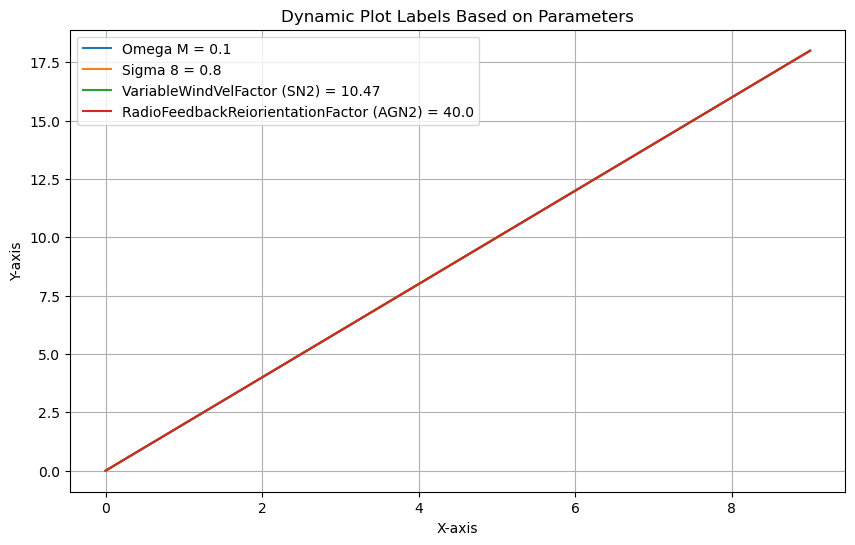

In [10]:
# Function to get the label for a dataset
def get_label(dataset_id):
    entry = parameter_dict.get(dataset_id, {})
    return f"{entry.get('parameter', 'Unknown')} = {entry.get('value', 'N/A')}"

# Sample dataset identifiers
datasets = ["1P_p1_n2", "1P_p2_0", "1P_p5_1", "1P_p6_2"]

# Simulated data for plotting
x = range(10)  # Example x values
y_values = {dataset: [val + i for i, val in enumerate(x)] for dataset in datasets}  # Example y values

# Plotting
plt.figure(figsize=(10, 6))
for dataset, y in y_values.items():
    label = get_label(dataset)  # Get dynamic label
    plt.plot(x, y, label=label)

# Customizing the plot
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Dynamic Plot Labels Based on Parameters")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [7]:

def schechter(M, alpha, M_star, phi_star):
    return 0.4 * np.log(10) * phi_star * (10 ** (0.4 * (M_star - M))) ** (alpha + 1) * np.exp(-10 ** (0.4 * (M_star - M)))

# Define parameters and simulations
parameters = ['OmegaM', 'Sigma8', 'SN1', 'AGN1', 'SN2', 'AGN2']
param_labels = ['Ωm', 'σ8', 'ASN1', 'AAGN1', 'ASN2', 'AAGN2']
simulations = ['IllustrisTNG', 'SIMBA', 'Astrid']#, 'Swift-EAGLE']

# Set up the plot
fig, axes = plt.subplots(len(simulations), len(parameters), figsize=(24, 18), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

# Color map for different parameter values
colors = plt.cm.viridis(np.linspace(0, 1, 5))

def plot_1p_uvlfs(redshift='z0.1', category='attenuated', band='GALEX FUV'):
    config = get_config(dataset="1P", simulation=simulations[0])
    
    for i, sim in enumerate(simulations):
        sim_config = get_config(dataset="1P", simulation=sim)
        
        for j, (param, param_label) in enumerate(zip(parameters, param_labels)):
            ax = axes[i, j]
            
            # Construct data directory path
            data_dir = sim_config["lf_data_dir"][category]["GALEX"]
            variations = ['n2', 'n1', '1', '2']
            
            for k, var in enumerate(variations):
                filename = os.path.join(data_dir, redshift,
                                     f"UVLF_1P_p{j+1}_{var}_{get_safe_name(band)}_{redshift}_{category}.txt")
                
                try:
                    df = pd.read_csv(filename, sep='\t')
                    
                    # Plot UVLF with error bars
                    ax.errorbar(
                        df['magnitude'], df['phi'], 
                        yerr=df['phi_sigma'],
                        fmt='o-', color=colors[k], 
                        capsize=5, markersize=4, linewidth=1.5
                    )
                    
                    # Fit Schechter function
                    try:
                        initial_guess = [-1.55, -19.49, 1.69e-3]
                        popt, _ = curve_fit(schechter, df['magnitude'], df['phi'], p0=initial_guess)
                        M_range = np.linspace(min(df['magnitude']), max(df['magnitude']), 100)
                        phi_fit = schechter(M_range, *popt)
                        ax.plot(M_range, phi_fit, '--', color=colors[k], alpha=0.5)
                    except:
                        print(f"Could not fit Schechter function for {filename}")
                        
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
            
            # Customize plot
            ax.set_yscale('log')
            ax.grid(True, alpha=0.3)
            
            # Labels
            if i == len(simulations) - 1:
                ax.set_xlabel('M$_{AB}$')
            if j == 0:
                ax.set_ylabel('$\phi$ [Mpc$^{-3}$ mag$^{-1}$]')
            if i == 0:
                ax.set_title(param_label)
            
            # Add simulation name
            if j == len(parameters) - 1:
                ax.text(1.05, 0.5, sim, transform=ax.transAxes, rotation=-90, va='center')

    # Save plot
    output_dir = os.path.join(config["base_dir"], "plots", "1P_UVLFs")
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f'UVLF_1P_variations_{redshift}_{category}.pdf'), 
                bbox_inches='tight', dpi=300)
    plt.close()

# Create plots for different redshifts
for redshift in ['z0.1', 'z1.0', 'z1.5', 'z2.0']:
    plot_1p_uvlfs(redshift=redshift, category='attenuated', band='GALEX FUV')